# CNN-RNN 아키텍처를 사용한 비디오 분류

**Author:** [Sayak Paul](https://twitter.com/RisingSayak)<br>
**Date created:** 2021/05/28<br>
**Last modified:** 2021/06/05<br>
**Description:** UCF101 데이터 세트에서 전이 학습 및 순환 모델을 사용하여 비디오 분류기를 훈련합니다.

이 예는 비디오 분류, 권장 사항, 보안 등의 애플리케이션에 대한 중요한 사용 사례를 보여줍니다.
[UCF101 데이터 세트](https://www.crcv.ucf.edu/data/UCF101.php)를 사용하겠습니다.
동영상 분류기를 구축합니다. 데이터 세트는 크리켓 슛, 펀치, 자전거 타기 등과 같은 다양한 동작으로 분류된 비디오로 구성됩니다. 이 데이터 세트는 일반적으로 비디오 분류의 응용 프로그램인 동작 인식기를 구축하는 데 사용됩니다.

비디오는 순서가 지정된 프레임 시퀀스로 구성됩니다. 각 프레임에는 *공간* 정보가 포함되어 있으며 이러한 프레임의 시퀀스에는 *시간적* 정보가 포함되어 있습니다. 이 두 가지 측면을 모두 모델링하기 위해 우리는 컨볼루션(공간 처리용)과 순환 레이어(시간 처리용)로 구성된 하이브리드 아키텍처를 사용합니다.
특히 [GRU 레이어](https://keras.io/api/layers/recurrent_layers/gru/)로 구성된 CNN(Convolutional Neural Network)과 RNN(Recurrent Neural Network)을 사용합니다.
이러한 종류의 하이브리드 아키텍처는 일반적으로 **CNN-RNN**으로 알려져 있습니다.

이 예제에는 TensorFlow 2.5 이상이 필요하며 다음 명령을 사용하여 설치할 수 있는 TensorFlow Docs가 필요합니다.

In [ ]:
!pip install -q git+https://github.com/tensorflow/docs

## 데이터 수집

이 예제의 런타임을 비교적 짧게 유지하기 위해 원본 UCF101 데이터 세트의 서브샘플링된 버전을 사용할 것입니다. [이 노트](https://colab.research.google.com/github/sayakpaul/Action-Recognition-in-TensorFlow/blob/main/Data_Preparation_UCF101.ipynb)를 참조할 수 있습니다.
서브샘플링이 어떻게 수행되었는지 알 수 있습니다.

In [ ]:
!wget -q https://git.io/JGc31 -O ucf101_top5.tar.gz
!tar xf ucf101_top5.tar.gz

## 설정

In [ ]:
!pip install imutils

In [ ]:
from tensorflow_docs.vis import embed
from tensorflow import keras
from imutils import paths

import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import imageio
import cv2
import os

## 하이퍼파라미터 정의

In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 64
EPOCHS = 10

MAX_SEQ_LENGTH = 20
NUM_FEATURES = 2048

## 데이터 준비

In [123]:
train_df = pd.read_csv("./ucf101_top5/train.csv")
test_df = pd.read_csv("./ucf101_top5/test.csv")

print(f"Total videos for training: {len(train_df)}")
print(f"Total videos for testing: {len(test_df)}")

train_df.sample(20)

Total videos for training: 594
Total videos for testing: 224


,video_name,tag
39,v_CricketShot_g13_c05.avi,CricketShot
51,v_CricketShot_g15_c03.avi,CricketShot
524,v_TennisSwing_g14_c07.avi,TennisSwing
82,v_CricketShot_g20_c04.avi,CricketShot
552,v_TennisSwing_g19_c01.avi,TennisSwing
375,v_ShavingBeard_g10_c03.avi,ShavingBeard
244,v_Punch_g08_c07.avi,Punch
146,v_PlayingCello_g12_c02.avi,PlayingCello
167,v_PlayingCello_g15_c05.avi,PlayingCello
264,v_Punch_g11_c07.avi,Punch


비디오 분류기 훈련의 많은 과제 중 하나는 비디오를 네트워크에 공급하는 방법을 찾는 것입니다. [이 블로그 포스트](https://blog.coast.ai/five-video-classification-methods-implemented-in-keras-and-tensorflow-99cad29cc0b5)
그런 다섯 가지 방법에 대해 설명합니다. 비디오는 순서가 지정된 프레임 시퀀스이므로 프레임을 추출하여 3D 텐서에 넣을 수 있습니다. 그러나 프레임 수는 비디오마다 다를 수 있으므로 (패딩을 사용하지 않는 한) 일괄 처리로 쌓을 수 없습니다. 대안으로 **최대 프레임 수에 도달할 때까지 고정된 간격으로 비디오 프레임을 저장할 수 있습니다**. 이 예에서 우리는 할 것입니다
다음과 같은:

1. 비디오의 프레임을 캡처합니다.
2. 최대 프레임 수에 도달할 때까지 비디오에서 프레임을 추출합니다.
3. 비디오의 프레임 수가 최대 프레임 수보다 적은 경우 비디오를 0으로 채웁니다.

이 워크플로는 [텍스트 시퀀스 관련 문제](https://developers.google.com/machine-learning/guides/text-classification/)와 동일합니다. UCF101 데이터 세트의 비디오는 프레임 간 개체 및 동작의 극단적인 변화를 포함하지 않는 [알려진](https://www.crcv.ucf.edu/papers/UCF101_CRCV-TR-12-01.pdf)입니다. 이 때문에 학습 작업에 대해 몇 가지 프레임만 고려하는 것이 좋습니다. 그러나 이 접근 방식은 다른 비디오 분류 문제에 잘 일반화되지 않을 수 있습니다. 우리는 사용할 것입니다
[OpenCV의 'VideoCapture()' 메서드](https://docs.opencv.org/master/dd/d43/tutorial_py_video_display.html) 동영상에서 프레임을 읽습니다.

In [151]:
# The following two methods are taken from this tutorial:
# https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub


def crop_center_square(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
#     print(min_dim)
    start_x = (x // 2) - (min_dim // 2)  # 320//2 - 240//2 => 160 0 120 => 40
    start_y = (y // 2) - (min_dim // 2)  # 240//2 - 240//2 => 0
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]
                   #  0:240 , 40:280


def load_video(path, max_frames=0, resize=(IMG_SIZE, IMG_SIZE)):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
#             print(frame.shape)
            if not ret:
                break
            frame = crop_center_square(frame)
#             print(frame.shape)
            frame = cv2.resize(frame, resize)
#             print(frame.shape)
            frame = frame[:, :, [2, 1, 0]]
#             print(frame.shape)
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames)


사전 훈련된 네트워크를 사용하여 추출된 프레임에서 의미 있는 기능을 추출할 수 있습니다.
[`Keras 애플리케이션`](https://keras.io/api/applications/) 모듈은 [ImageNet-1k 데이터 세트](http:// image-net.org/).
이를 위해 [InceptionV3 모델](https://arxiv.org/abs/1512.00567)을 사용할 것입니다.

In [ ]:

def build_feature_extractor():
    feature_extractor = keras.applications.InceptionV3(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = keras.applications.inception_v3.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")


feature_extractor = build_feature_extractor()

비디오의 레이블은 문자열입니다. 신경망은 문자열 값을 이해하지 못하므로 모델에 제공하기 전에 숫자 형식으로 변환해야 합니다. 여기에서는 [`StringLookup`](https://keras.io/api/layers/preprocessing_layers/categorical/string_lookup) 레이어를 사용하여 클래스 레이블을 정수로 인코딩합니다.

In [ ]:
label_processor = keras.layers.StringLookup(
    num_oov_indices=0, vocabulary=np.unique(train_df["tag"])
)
print(label_processor.get_vocabulary())

마지막으로 모든 조각을 모아 데이터 처리 유틸리티를 만들 수 있습니다.

In [159]:
df = train_df
root_dir = "./ucf101_top5/train"
num_samples = len(df)
# print(num_samples)
video_paths = df["video_name"].values.tolist()
labels = df["tag"].values
# print(labels.shape)
# print(labels[..., None].shape)
# print(labels)
labels = label_processor(labels[..., None]).numpy()
# print(labels)
frame_masks = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH), dtype="bool")
print(frame_masks.shape)
frame_features = np.zeros(
    shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
)
print(frame_features.shape)

print(video_paths[0])
frames = load_video(os.path.join(root_dir, video_paths[0]))
print(frames.shape)
frames = frames[None, ...]
print(frames.shape)
temp_frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
print(temp_frame_mask.shape)
temp_frame_features = np.zeros(
    shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
)
print(temp_frame_features.shape)
for i, batch in enumerate(frames[:1]):
    print(batch.shape)
    video_length = batch.shape[0]
    print(video_length)
    length = min(MAX_SEQ_LENGTH, video_length)
    print(length)
    print(batch[None, 0, :].shape)
    for j in range(length):
        temp_frame_features[i, j, :] = feature_extractor.predict(
            batch[None, j, :]
        )
    temp_frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked
    print(temp_frame_mask)

frame_features[0,] = temp_frame_features.squeeze()
print(frame_features.shape)
frame_masks[0,] = temp_frame_mask.squeeze()
print(frame_masks.shape)

(594, 20)
(594, 20, 2048)
v_CricketShot_g08_c01.avi
(75, 224, 224, 3)
(1, 75, 224, 224, 3)
(1, 20)
(1, 20, 2048)
(75, 224, 224, 3)
75
20
(1, 224, 224, 3)
[[ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True]]
(594, 20, 2048)
(594, 20)


In [160]:

def prepare_all_videos(df, root_dir):
    num_samples = len(df)
    video_paths = df["video_name"].values.tolist()
    labels = df["tag"].values
    labels = label_processor(labels[..., None]).numpy()

    # `frame_masks` and `frame_features` are what we will feed to our sequence model.
    # `frame_masks` will contain a bunch of booleans denoting if a timestep is
    # masked with padding or not.
    frame_masks = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH), dtype="bool")
    frame_features = np.zeros(
        shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
    )

    # For each video.
    for idx, path in enumerate(video_paths):
        # Gather all its frames and add a batch dimension.
        frames = load_video(os.path.join(root_dir, path))
        frames = frames[None, ...]

        # Initialize placeholders to store the masks and features of the current video.
        temp_frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
        temp_frame_features = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )

        # Extract features from the frames of the current video.
        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
                temp_frame_features[i, j, :] = feature_extractor.predict(
                    batch[None, j, :]
                )
            temp_frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

        frame_features[idx,] = temp_frame_features.squeeze()
        frame_masks[idx,] = temp_frame_mask.squeeze()

    return (frame_features, frame_masks), labels


train_data, train_labels = prepare_all_videos(train_df, "./ucf101_top5/train")
test_data, test_labels = prepare_all_videos(test_df, "./ucf101_top5/test")

print(f"Frame features in train set: {train_data[0].shape}")
print(f"Frame masks in train set: {train_data[1].shape}")

Frame features in train set: (594, 20, 2048)
Frame masks in train set: (594, 20)


위의 코드 블록은 실행 중인 시스템에 따라 실행하는 데 ~20분이 소요됩니다.

## 시퀀스 모델

이제 이 데이터를 'GRU'와 같은 반복 계층으로 구성된 시퀀스 모델에 공급할 수 있습니다.

In [161]:
# Utility for our sequence model.
def get_sequence_model():
    class_vocab = label_processor.get_vocabulary()

    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

    # Refer to the following tutorial to understand the significance of using `mask`:
    # https://keras.io/api/layers/recurrent_layers/gru/
    x = keras.layers.GRU(16, return_sequences=True)(    # (N,T,D)(N,H) => (64,20,2048)(64,16)
        frame_features_input, mask=mask_input
    )
    x = keras.layers.GRU(8)(x)                          # (64,20,16)(64,8)                    
    x = keras.layers.Dropout(0.4)(x)                    # (64,20,8)
    x = keras.layers.Dense(8, activation="relu")(x)     # (64,20*8)(8,8)
    output = keras.layers.Dense(len(class_vocab), activation="softmax")(x)  # (64,20*8)(8,5) => (64,5)

    rnn_model = keras.Model([frame_features_input, mask_input], output)

    rnn_model.compile(
        loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )
    return rnn_model


# Utility for running experiments.
def run_experiment():
    filepath = "video_classifier"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )

    seq_model = get_sequence_model()
    history = seq_model.fit(
#         [train_data[0], train_data[1]],
        train_data,
        train_labels,
        validation_split=0.3,
        epochs=EPOCHS,
        callbacks=[checkpoint],
    )

    seq_model.load_weights(filepath)
    _, accuracy = seq_model.evaluate([test_data[0], test_data[1]], test_labels)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history, seq_model


_, sequence_model = run_experiment()

Epoch 1/10
11/13 [========================>.....] - ETA: 0s - loss: 1.4428 - accuracy: 0.3608
Epoch 00001: val_loss improved from inf to 1.86401, saving model to video_classifier
13/13 [==============================] - 6s 141ms/step - loss: 1.4132 - accuracy: 0.3855 - val_loss: 1.8640 - val_accuracy: 0.1117
Epoch 2/10
13/13 [==============================] - ETA: 0s - loss: 1.0933 - accuracy: 0.6434
Epoch 00002: val_loss did not improve from 1.86401
13/13 [==============================] - 0s 30ms/step - loss: 1.0933 - accuracy: 0.6434 - val_loss: 1.8794 - val_accuracy: 0.3184
Epoch 3/10
13/13 [==============================] - ETA: 0s - loss: 0.9604 - accuracy: 0.6843
Epoch 00003: val_loss did not improve from 1.86401
13/13 [==============================] - 0s 30ms/step - loss: 0.9604 - accuracy: 0.6843 - val_loss: 1.9850 - val_accuracy: 0.3128
Epoch 4/10
13/13 [==============================] - ETA: 0s - loss: 0.8775 - accuracy: 0.7566
Epoch 00004: val_loss did not improve from 1.8

**참고**: 이 예제의 런타임을 비교적 짧게 유지하기 위해 몇 가지 교육 예제만 사용했습니다. 이 훈련 예제의 수는 99,909개의 훈련 가능한 매개변수가 있는 사용 중인 시퀀스 모델과 관련하여 적습니다. 언급된 [노트북](https://colab.research.google.com/github/sayakpaul/Action-Recognition-in-TensorFlow/blob/main/Data_Preparation_UCF101.ipynb)을 사용하여 UCF101 데이터 세트에서 더 많은 데이터를 샘플링하는 것이 좋습니다. 위와 같은 모델을 학습시킵니다.

## Inference

Test video path: ./ucf101_top5/test/v_TennisSwing_g05_c01.avi
  CricketShot: 36.28%
  Punch: 18.38%
  ShavingBeard: 17.82%
  PlayingCello: 15.33%
  TennisSwing: 12.19%



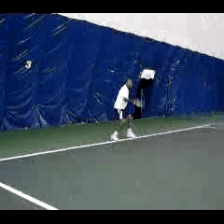

In [164]:

def prepare_single_video(frames):
    frames = frames[None, ...]
    frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
    frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    for i, batch in enumerate(frames):
        video_length = batch.shape[0]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            frame_features[i, j, :] = feature_extractor.predict(batch[None, j, :])
        frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

    return frame_features, frame_mask


def sequence_prediction(path):
    class_vocab = label_processor.get_vocabulary()
    frames = load_video(path)
    frame_features, frame_mask = prepare_single_video(frames)
    probabilities = sequence_model.predict([frame_features, frame_mask])[0]

    for i in np.argsort(probabilities)[::-1]:
        print(f"  {class_vocab[i]}: {probabilities[i] * 100:5.2f}%")
    return frames


# This utility is for visualization.
# Referenced from:
# https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub
def to_gif(images):
    converted_images = images.astype(np.uint8)
    imageio.mimsave("animation.gif", converted_images, fps=10)
    return embed.embed_file("animation.gif")


test_video = np.random.choice(test_df["video_name"].values.tolist())
test_video = "./ucf101_top5/test/"+test_video
print(f"Test video path: {test_video}")
test_frames = sequence_prediction(test_video)
to_gif(test_frames[:MAX_SEQ_LENGTH])